In [1]:
import sys
sys.path.insert(0,'python')
from classification import *
import pylab as plt
from fastRWpkl import *
from readSent import *
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
import cPickle as pkl
import numpy as np
import scipy
from scipy import signal
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter
import cPickle as pkl
import pylab as plt
from scipy.fftpack import dct, idct
import scipy.stats
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
from scipy import optimize
import matplotlib.patches as patches
from geo_trans import *
%matplotlib inline

In [2]:
modis_sent = parallel_rw_pkl(None,'patch15MS','r')
patch15Sen = parallel_rw_pkl(None, 'patch15Sen', 'r')

cm = parallel_rw_pkl(None, '0510diacm', 'r')[1000:2000,5000:6000]
Sindex = parallel_rw_pkl(None, 'Sindex', 'r')
centers = Sindex

In [3]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(p, process, sent_cut, modis_sen):    
    xstd,ystd,angle, sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]          
    
    for ii,cx in enumerate(patchx):
        cy = patchy[ii] - 5000
        cx -= 1000
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
        brdf = modis_sen[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs

solved = []
to_regs = []
for ii,sen_cut in enumerate(patch15Sen):
    p = np.array([140., 240.,45., -20,73.34353532])
    psolve = optimize.fmin(cost,p, full_output=1,args=(([1,5],), sen_cut, modis_sent[ii]))
    solved.append(psolve)
    to_regs.append(to_regression)
    print 'solved one: ', psolve, '\n'

patch 15
costs: 0.0376909740098 rvalue:  0.96230902599 slop:  1.21945762759 
parameters:  [ 140.          240.           45.          -20.           73.34353532] 

patch 15
costs: 0.0377073321502 rvalue:  0.96229266785 slop:  1.21947971228 
parameters:  [ 147.          240.           45.          -20.           73.34353532] 

patch 15
costs: 0.0376922475676 rvalue:  0.962307752432 slop:  1.21946180925 
parameters:  [ 140.          252.           45.          -20.           73.34353532] 

patch 15
costs: 0.0376935439047 rvalue:  0.962306456095 slop:  1.2194495915 
parameters:  [ 140.          240.           47.25        -20.           73.34353532] 

patch 15
costs: 0.0374013217105 rvalue:  0.962598678289 slop:  1.22039258462 
parameters:  [ 140.          240.           45.          -21.           73.34353532] 

patch 15
costs: 0.0444781503302 rvalue:  0.95552184967 slop:  1.20504113869 
parameters:  [ 140.          240.           45.          -20.           77.01071209] 

patch 15
costs

<ipython-input-3-3f971194b602>:58: SyntaxWarning: name 'to_regression' is assigned to before global declaration
  global to_regression
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [4]:
solved

[(array([  26.45694669,  322.29550124,   69.66248266,  -21.87057909,
           56.99999995]), 0.022862285865322018, 316, 562, 0),
 (array([  21.80774304,  264.40639174,   35.52117685,  -21.99999999,
           61.00000021]), 0.016396883967468523, 347, 617, 0),
 (array([  27.28211136,  265.27723972,   74.66377407,  -21.99999998,
           56.97416293]), 0.017110943633466436, 348, 611, 0),
 (array([ 19.03620705,  33.38972621,  -3.54135811, -23.39106896,  57.60204054]),
  0.038549460684202397,
  578,
  1001,
  1),
 (array([ 38.27531242,  24.93772545,  59.5348467 , -26.99348865,  58.72877967]),
  0.042809503727246456,
  580,
  1001,
  1),
 (array([ 235.39904645,   48.06273998,   60.51563772,  -21.02769512,
           72.37272893]), 0.035921757199395055, 577, 1001, 1),
 (array([ 31.12060165,  47.39621838,  41.77281114, -15.98873756,  72.00812598]),
  0.021057868495766852,
  570,
  1000,
  1)]

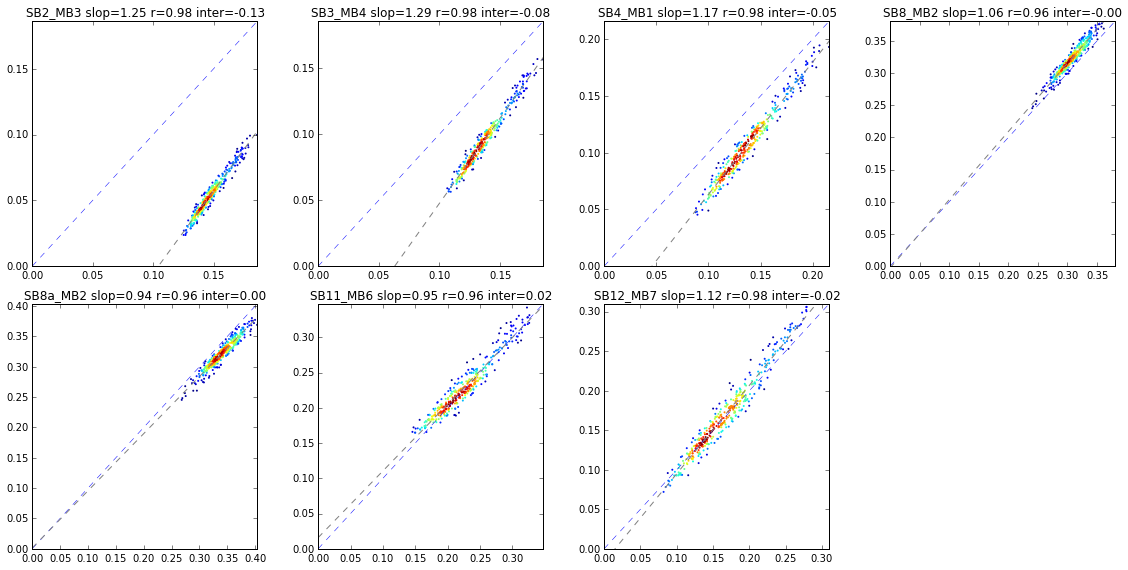

In [52]:
fig = plt.figure
gs = gridspec.GridSpec(2,4)  # generate a grid space
fig = plt.figure(figsize=(16,8))
names = ('SB2_MB3,SB3_MB4,SB4_MB1,SB8_MB2,SB8a_MB2,SB11_MB6,SB12_MB7').split(',')
for i in range(7):
    ax = fig.add_subplot(gs[i])
    
    data = np.array(to_regs[i])
    maxval = np.nanmax(data)
    m = data[:,0][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    s = data[:,1][~(np.isnan(data[:,1])|np.isnan(data[:,0]))]
    
    dif = m-s
    sigma = np.nanstd(dif)
    mean = np.nanmean(dif)
    
    Thr_sigma = 3.*sigma
    inliers = (dif < mean+3*sigma)&(dif > mean-3*sigma)
    
    m = m[inliers]
    s = s[inliers]

    r = scipy.stats.linregress(m,s) # all of the data composed of mean value and brdf
    fit = np.polyfit(m,s,1)
    fit_fn = np.poly1d(fit)
    #plt.figure(figsize = (7,7))
    xy = np.vstack([m,s])
    z = gaussian_kde(xy)(xy)
    ax.scatter(m,s, c=z, s=4, edgecolor='')
    ax.plot([0,1],[0.,1], '--',linewidth=0.5)
    ax.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
    ax.set_xlim(0, maxval)
    ax.set_ylim(0, maxval)
    ax.set_title('%s'%names[i]+' slop=%.2f'%r.slope+' r=%.2f'%r.rvalue+' inter=%.2f'%r.intercept)
plt.tight_layout()
plt.savefig('img/patch15_regression2.pdf')

In [ ]:
fhead = 'data/50SMG20165100'

def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus, ygaus)
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2: center[0]+xwin/2, center[1]-ywin/2:center[1]+ywin/2]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

def cost(process, sent_cut, modis_sen,p):    
    xstd,ystd,angle, sx, sy = p
    xwin,ywin = 100,100
    
    i, j = 1,5
    print 'patch %s%s'%(i,j)
    
    #modis_cut = modis_sent[s1,s2]*0.001
    in_patch = (centers[0]>=i*1000)&(centers[0]<i*1000+1000)&(centers[1]>=j*1000)&(centers[1]<j*1000+1000)
    patchx, patchy = (centers[0])[in_patch], (centers[1])[in_patch]
    
    to_regression =[]          
    
    for ii,cx in enumerate(patchx):
        cy = patchy[ii] - 5000
        cx -= 1000
        minx = cx+sx - 50
        maxx = cx+sx + 50
        miny = cy+sy - 50
        maxy = cy+sy + 50

        to_conv = sen_cut[max(0, minx): min(1000, maxx), max(0, miny): min(1000, maxy)]
        brdf = modis_sen[cx,cy]*0.001

        if (to_conv.shape[0]==100) & (to_conv.shape[1]==100) & (brdf!=np.nan):
            To_conv = to_conv
            Brdf = brdf
            nanval = np.where(~((To_conv < 1)&(To_conv > 0)))
            To_conv[nanval[0], nanval[1]] = np.nanmean(To_conv)
            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                              
            ker = gaus/(gaus.sum())

            s = signal.fftconvolve(To_conv, ker, mode='valid')
            to_regression.append([s[0][0], Brdf])
    
    x,y = np.array(to_regression).T
    global to_regression
    nanm = (np.isnan(x))|(np.isnan(y))
    r = scipy.stats.linregress(x[~nanm],y[~nanm])
    costs = abs(1-r.rvalue)
    print 'costs:', costs, 'rvalue: ', r.rvalue, 'slop: ', r.slope, '\n', 'parameters: ', p,'\n'
    

    return costs

solved = []
to_regs = []
for ii,sen_cut in enumerate(patch15Sen):
    p = np.array([140., 240.,45., -20.,56.])
    par = partial(cost, ([1,5],), sen_cut, modis_sent[ii])
    psolve = scipy.optimize.basinhopping(par,p, 
                niter=1000, minimizer_kwargs = {"method":"L-BFGS-B"})
    solved.append(psolve)
    to_regs.append(to_regression)
    print 'solved one: ', psolve, '\n'

patch 15
costs: 0.0241843276037 rvalue:  0.975815672396 slop:  1.27942027916 
parameters:  [ 140.  240.   45.  -20.   56.] 

patch 15
costs: 0.0241843276037 rvalue:  0.975815672396 slop:  1.27942027916 
parameters:  [ 140.00000001  240.           45.          -20.           56.        ] 

patch 15
costs: 0.0241843276037 rvalue:  0.975815672396 slop:  1.27942027916 
parameters:  [ 140.          240.00000001   45.          -20.           56.        ] 

patch 15
costs: 0.0241843276037 rvalue:  0.975815672396 slop:  1.27942027916 
parameters:  [ 140.          240.           45.00000001  -20.           56.        ] 

patch 15
costs: 0.0241843276037 rvalue:  0.975815672396 slop:  1.27942027916 
parameters:  [ 140.          240.           45.          -19.99999999   56.        ] 

patch 15
costs: 0.0241843276037 rvalue:  0.975815672396 slop:  1.27942027916 
parameters:  [ 140.          240.           45.          -20.           56.00000001] 

patch 15
costs: 0.0241837559921 rvalue:  0.9758162

Optimization on each band based on small patches.

In [30]:
solves = []
fnames = ['gopb2_modis','gopb3_modis','gopb4_modis',
         'gopb8_modis','gopb8a_modis', 'igopb11_modis','igopb12_modis']
for i in fnames:
    data = parallel_rw_pkl(None, i, 'r')
    solve = []
    for i in data:
        for j in i:
            solve.append([j[0], j[1], j[2][0][0], j[2][0][1], j[2][0][2],j[2][1]])
    solves.append(solve)

35.5777710838
102.819524168
33.6420965499


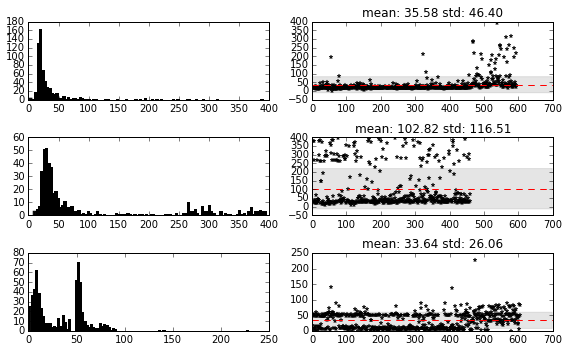

In [51]:
fig = plt.figure(figsize = (8,8))
x = np.array(solves).reshape(700, 6).T
for i,j in enumerate(x[2:-1, :]):
    s = i*2
    
    data = j[(j<400)&(j>0)]
    ax = fig.add_subplot(5,2,s+1)
    ax.hist(data, bins = 100, color='k')
    ax = fig.add_subplot(5,2,s+2)
    ax.plot(data,'k*', markersize=4)
    ax.plot([0,700],[np.nanmean(data), np.nanmean(data)], 'r--')
    ax.plot([0,700],[np.nanmean(data), np.nanmean(data)], 'r--')
    ax.fill_between(range(700), np.nanmean(data)-np.nanstd(data), np.nanmean(data)+np.nanstd(data), alpha=0.2, color='gray')
    ax.set_title('mean: %.2f std: %.2f'%(np.nanmean(data), np.nanstd(data)))
    print np.nanmean(data)
plt.tight_layout()

In [ ]:
np.nanmean(data)